In [1]:
import utils.dataset_utils as dataset
import utils.train_utils as train

import os
import numpy as np
import copy
import pickle
import glob

from sklearn.base import BaseEstimator
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.fft import fft, ifft, fftfreq

from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['figure.dpi'] = 500
plt.rcParams['lines.linewidth'] = 0.75

from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

print(torch.cuda.is_available())

False


#### USE KALMAN FILTER TO SMOOTH RESULT? Not necessary

#### Is FFT or RFFT more stable with gradient descent? Equally stable RFFT is just faster
#### weight normalization?
#### seperate training of the last layer? Yes
#### Use different padding (first make the signal bigger than smaller)?

#### Use CNN or GRU to smooth the output? Gru does not work
#### Does RAMAN also need smoothing? Yes
#### tiny no hidden layers seems to work a bit less good than with hidden layers. One difference is that the photo is not as smooth.
#### larger CNN seems to train faster, but they risk overfitting

#### Pretraining works better than not pretraining.

#### Dependency tests:
Raw, photo or raman to Raman with CNN does not work

Training Raman from Raw+Photo from start does work.

Training Raman from Raw+Raman from start gives weird intermediate results but does work. When using pretraining it seems to give better results at least for the intermediate results.

Training Raman from Photo+Raman does work with pretraining (can not be trained from start)

Training Raman from All does work.

Training Photo from Raw does not work.

Training Photo and Raman from raw does not work, but it seems to work better than when they are seperatly trained from raw (however the network used was bigger).

In [2]:
def unit_vector_norm(X):
    return (X.T / np.sqrt((X**2).sum(axis=1))).T

In [3]:
# # DESKTOP
# file_locations = ["../data/Raman_Mouse/preprocessed_2022-11-30 11-48-26.672496/",
#                   "../data/Raman_Mouse/raman_2022-11-30 12-16-11.285597/",
#                   "../data/Raman_Mouse/photoluminences_2022-11-30 12-16-25.050493/"]
# LAPTOP
file_locations = ["../data/Raman_Mouse/preprocessed_2022-12-01 11-53-44.127304/",
                  "../data/Raman_Mouse/raman_2022-12-01 12-13-34.452351/",
                  "../data/Raman_Mouse/photoluminences_2022-12-01 12-13-35.526177/"]
# filenames = [sorted(glob.glob(file_location+'/[!Wave|!Liver|!Kidney]*.npy')) for file_location in file_locations]
# filenames = [sorted(glob.glob(file_location+'/[!Wave|!muscle]*.npy')) for file_location in file_locations]
filenames = [sorted(glob.glob(file_location+'/[!Wave]*.npy')) for file_location in file_locations]

saved_NN = "test_NN"
os.makedirs(saved_NN, exist_ok=True)

basenames = [[os.path.splitext(os.path.basename(f))[0] for f in filename] for filename in filenames]

# check if all files exist
for name in basenames[0]:
    if not [b for b in basenames[1] if name in b]:
        raise ValueError(f"file {name} does not exist in the raman folder.")
    if not [b for b in basenames[2] if name in b]:
        raise ValueError(f"file {name} does not exist in the photo folder.")

if len(filenames[0]) != len(filenames[1]) or len(filenames[1]) != len(filenames[2]):
    raise ValueError("The folder do not have the same number of files.")
        

with open(f"{'/'.join(file_locations[0].split('/')[:-2])}/Sample_labels.pickle", 'rb') as f:
    labels = pickle.load(f)
labels = {l.split(".")[0]: val for l, val in labels.items()}
labels = list(zip(*sorted(labels.items())))[1]

wavenumbers = np.load(f"{file_locations[2]}Wavenumbers.npy")

NORM = False
func = unit_vector_norm if NORM else lambda x:x
    
data = []
for filename in filenames:
    tmp = []
    for f in filename: 
        x = np.load(f)
        tmp.append(func(x.reshape(-1,x.shape[-1])).reshape(x.shape))
    data.append(tmp)
data.append(labels)

data = list(zip(*data))

In [4]:
# data = data[:1]
# len(data)

In [5]:
nn.ReLU
nn.GELU
nn.LeakyReLU
nn.ELU

"""
Keep sum of weights positive,
imag part must be zero (loss function)
"""

class SelectLayer(nn.Module):
    def __init__(self, layer_index):
        super().__init__()
        self.layer_index = layer_index

    def forward(self, x):
        return x[:,self.layer_index]

class Conv_FFT(nn.Module):
    def __init__(self, num_input_channels : int = 2, base_channel_size: int = 16, act_fn : object = nn.GELU, groups : int = 2, **kwargs):
        super().__init__()
        c_hid = base_channel_size
        c_hid_2 = base_channel_size //2
            
        # FFT CNN split
        self.net = nn.Sequential(
            nn.Conv1d(num_input_channels, c_hid, kernel_size=11, padding=5, groups=groups, bias=False), 
            act_fn(),
            nn.Conv1d(c_hid, c_hid, kernel_size=9, padding=4, groups=groups, bias=False),
            act_fn(),
#             nn.Conv1d(c_hid, c_hid, kernel_size=7, padding=3, groups=groups, bias=False),
#             act_fn(),
#             nn.Conv1d(c_hid, c_hid, kernel_size=7, padding=3, groups=groups, bias=False),
#             act_fn(),
            nn.Conv1d(c_hid, c_hid, kernel_size=7, padding=3, groups=groups, bias=False),
            act_fn(),
            nn.Conv1d(c_hid, c_hid, kernel_size=7, padding=3, groups=2*groups, bias=False),
            act_fn(),
            nn.Conv1d(c_hid, c_hid, kernel_size=5, padding=2, groups=2*groups, bias=False),
            act_fn(),
#             nn.Conv1d(c_hid, c_hid, kernel_size=5, padding=2, groups=2*groups, bias=False),
#             act_fn(),
#             nn.Conv1d(c_hid, c_hid, kernel_size=5, padding=2, groups=2*groups, bias=False),
#             act_fn(),
            nn.Conv1d(c_hid, c_hid, kernel_size=3, padding=1, groups=2*groups, bias=False),
            act_fn(),
            nn.Conv1d(c_hid, 2*num_input_channels, kernel_size=3, padding=1, groups=2*groups, bias=False)
        )
        
        # photo smooth part
        self.smooth_phase2 = nn.Sequential(
            SelectLayer(slice(1,2)),
            nn.Conv1d(1, c_hid_2, kernel_size=5, padding=2, groups=1, bias=False), 
            act_fn(),
            nn.Conv1d(c_hid_2, c_hid_2, kernel_size=5, padding=2, groups=1, bias=False), 
            act_fn(),
            nn.Conv1d(c_hid_2, c_hid_2, kernel_size=5, padding=2, groups=1, bias=False), 
            act_fn(),
#             nn.Conv1d(c_hid_2, c_hid_2, kernel_size=5, padding=2, groups=1, bias=False), 
#             act_fn(),
#             nn.Conv1d(c_hid_2, c_hid_2, kernel_size=5, padding=2, groups=1, bias=False), 
#             act_fn(),
            nn.Conv1d(c_hid_2, 1, kernel_size=3, padding=1, groups=1), 
            SelectLayer(0)
        )
        self.smooth_phase1 = nn.Sequential(SelectLayer(1))
        
        # raman acc part
        self.raman_phase3 = nn.Sequential(
#             SelectLayer(slice(0,3)),
            nn.Conv1d(3, c_hid_2, kernel_size=5, padding=2, groups=1, bias=False), 
            act_fn(),
            nn.Conv1d(c_hid_2, c_hid_2, kernel_size=5, padding=2, groups=1, bias=False), 
            act_fn(),
#             nn.Conv1d(c_hid_2, c_hid_2, kernel_size=5, padding=2, groups=1, bias=False), 
#             act_fn(),
#             nn.Conv1d(c_hid_2, c_hid_2, kernel_size=5, padding=2, groups=1, bias=False), 
#             act_fn(),
            nn.Conv1d(c_hid_2, c_hid_2, kernel_size=5, padding=2, groups=1, bias=False), 
            act_fn(),
            nn.Conv1d(c_hid_2, 1, kernel_size=3, padding=1, groups=1), 
            SelectLayer(0)
        )
        self.raman_phase1 = nn.Sequential(SelectLayer(2))
        
        self.set_training(0)
        
    def set_training(self, value):
        if value == 0:
            self.smooth = self.smooth_phase1
            self.raman = self.raman_phase1
        elif value == 1:
            self.smooth = self.smooth_phase2
            self.raman = self.raman_phase1
        elif value == 2:
            self.smooth = self.smooth_phase2
            self.raman = self.raman_phase3
            
    def forward(self, x):
        n_wavenumbers = x.shape[-1]
        d = 1
        x0 = torch.fft.rfft(x, dim=d, norm='backward')
        x0 = torch.stack((x0.real, x0.imag), 1)
        x0 = self.net(x0)
        x1, x2 = x0[:,[0,2]], x0[:,[1,3]]
        x1, x2 = torch.transpose(x1, -2, -1).contiguous(), torch.transpose(x2, -2, -1).contiguous()
        x1, x2 = torch.view_as_complex(x1), torch.view_as_complex(x2)
        x1, x2 = torch.fft.irfft(x1, n=n_wavenumbers, dim=d, norm='backward'), torch.fft.irfft(x2, n=n_wavenumbers, dim=d, norm='backward')
        x3 = torch.stack((x, x1, x2),1)
        return self.smooth(x3), self.raman(x3), x1, x2

#     def forward(self, x):
#         n_wavenumbers = x.shape[-1]
#         d = 1
#         x = torch.fft.fft(x, dim=d, norm='backward')
#         x = torch.stack((x.real, x.imag), 1)
#         x = self.net(x)
#         x1, x2 = x[:,[0,2]], x[:,[1,3]]
#         x1, x2 = torch.transpose(x1, -2, -1).contiguous(), torch.transpose(x2, -2, -1).contiguous()
#         x1, x2 = torch.view_as_complex(x1), torch.view_as_complex(x2)
#         x1, x2 = torch.fft.ifft(x1, dim=d, norm='backward').real, torch.fft.ifft(x2, dim=d, norm='backward').real
#         if self.pretraining:
#             return x1, x2
#         return self.smooth(x1.reshape(-1, 1, n_wavenumbers)).reshape(x.shape[0],-1), x2

    
#     def forward(self, x):
#         """
#         Normal CNN
#         """
#         x0 = x.reshape(-1, 1, x.shape[-1])
#         x0 = self.net(x0)
#         x1, x2 = x0[:,0].reshape(x.shape), x0[:,1].reshape(x.shape)
#         x3 = torch.stack((x, x1, x2),1)
#         return self.smooth(x3).reshape(x.shape[0],-1), self.raman(x3).reshape(x.shape[0],-1), x1, x2

In [6]:
class SupervisedClassifier(BaseEstimator):
    def __init__(self, **kwargs):
        self.kwargs = kwargs

        _use_cuda = torch.cuda.is_available() and kwargs['cuda']
        if _use_cuda:
            torch.backends.cudnn.enabled = True
            torch.backends.cudnn.benchmark = True
        self.device = torch.device('cuda' if _use_cuda else 'cpu')        
        print(f"device: {self.device}")
        
    def fit(self, data):
        self.model = Conv_FFT().to(self.device)

        parameters = filter(lambda x: x.requires_grad, self.model.parameters())
        self.optimizer = optim.Adam(parameters, lr=self.kwargs['lr'])                
        self.train_loader, self.test_loader = dataset.load_splitdata(data, self.kwargs['batch_size'])
            
        for epoch in range(self.kwargs['epochs']):
            if os.path.exists(f"{saved_NN}//Conv_FFT_model_epoch{epoch}.pt"):
                print(f"epoch {epoch} is already trained")
                if not os.path.exists(f"{saved_NN}//Conv_FFT_model_epoch{epoch+1}.pt"):
                    self.model = torch.load(f"{saved_NN}//Conv_FFT_model_epoch{epoch}.pt", map_location=self.device) 
                    parameters = filter(lambda x: x.requires_grad, self.model.parameters())
                    self.optimizer = optim.Adam(parameters, lr=self.kwargs['lr'])  
                continue 
                
            if epoch >= 3:
                self.model.set_training(1)
            if epoch >= 6:
                self.model.set_training(2)
                
            print('-'*50)
            print('Epoch {:3d}/{:3d}'.format(epoch, self.kwargs['epochs']))
            start_time = datetime.now()
            train.train(self.model, self.optimizer, self.train_loader, self.kwargs['loss_func'], self.kwargs['acc_func'], self.kwargs['log_step'], self.device)
            end_time = datetime.now()
            time_diff = relativedelta(end_time, start_time)
            print('Elapsed time: {}h {}m {}s'.format(time_diff.hours, time_diff.minutes, time_diff.seconds))
            train.test(self.model, self.test_loader, self.kwargs['loss_func'], self.kwargs['acc_func'], self.kwargs['log_step'], self.device)
            torch.save(self.model, f"{saved_NN}//Conv_FFT_model_epoch{epoch}.pt")
        return self
    
    def predict(self, data=None):
        """
        """
        if data is not None:
            _, dataloader = dataset.load_splitdata(data, self.kwargs['batch_size'], test_size=None)
            for batch_idx, (x, *y) in enumerate(dataloader):
                x = x.to(self.device)
                y_1, y_2, y_3, y_4 = self.model(x)
                y1, y2, *_ = y
                yield x.cpu().detach().numpy(), y1, y2, y_1.cpu().detach().numpy(), y_2.cpu().detach().numpy(), y_3.cpu().detach().numpy(), y_4.cpu().detach().numpy()
        else:
            for batch_idx, (x, *y) in enumerate(self.test_loader):
                x = x.to(self.device)
                y_1, y_2, *_ = self.model(x)
                y1, y2, *_ = y
                yield x.cpu().detach().numpy(), y1, y2, y_1.cpu().detach().numpy(), y_2.cpu().detach().numpy()

In [7]:
loss1 = nn.MSELoss(size_average=None, reduce=None, reduction='mean')
loss2 = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
# loss3 = nn.KLDivLoss(size_average=None, reduce=None, reduction='batchmean', log_target=False)
# both closely related
# loss4 = nn.HuberLoss(reduction='mean', delta=100.0)
# loss5 = nn.SmoothL1Loss(size_average=None, reduce=None, reduction='mean', beta=1.0)

def loss_func(y, y_, x):
    raman, photo, _ = y
    raman = raman.to(y_[0].device)
    photo = photo.to(y_[0].device)
    return loss1(y_[0], photo) + loss1(y_[1], raman)

def acc_func(y, y_, x, data="train"):
    y_1, y_2, y_3, y_4 = y_
    y_1, y_2, y_3, y_4 = y_1.cpu().detach().numpy(), y_2.cpu().detach().numpy(), y_3.cpu().detach().numpy(), y_4.cpu().detach().numpy()
    x = x.cpu().detach().numpy()
    plt.title(f"plot {data} data")
    plt.plot(x[0], label='raw')
    plt.plot(y_1[0] + y_2[0], label='raman+photo')
    plt.plot(np.abs(x[0]-y_1[0]-y_2[0]), label='noise', color='orange')
    plt.plot(y[0][0], label='raman', color='c')
    plt.plot(y[1][0], label='photo', color='r')
    plt.plot(y_1[0], label='Conv1/photo', color='g')
    plt.plot(y_2[0], label='Conv2/raman', color='brown')
    plt.plot(y_3[0], label='Conv/pre_photo', color='b')
    plt.plot(y_4[0], label='Conv/pre_raman', color='r')
    plt.ylim(ymin=-10)
    plt.xlim(xmin=0, xmax=1300)
    plt.legend()
    plt.show()
    return loss_func(y, y_, x)

In [8]:
BATCH_SIZE = 32
EPOCHS = 50

kwargs = {'batch_size': BATCH_SIZE,
          'cuda': True,
          'log_step': 5000,
          'epochs': EPOCHS,
          'loss_func': loss_func,
          'acc_func' : acc_func,
          'bias': True,
          'lr': 0.001
         }

device: cpu
--------------------------------------------------
Epoch   0/ 50


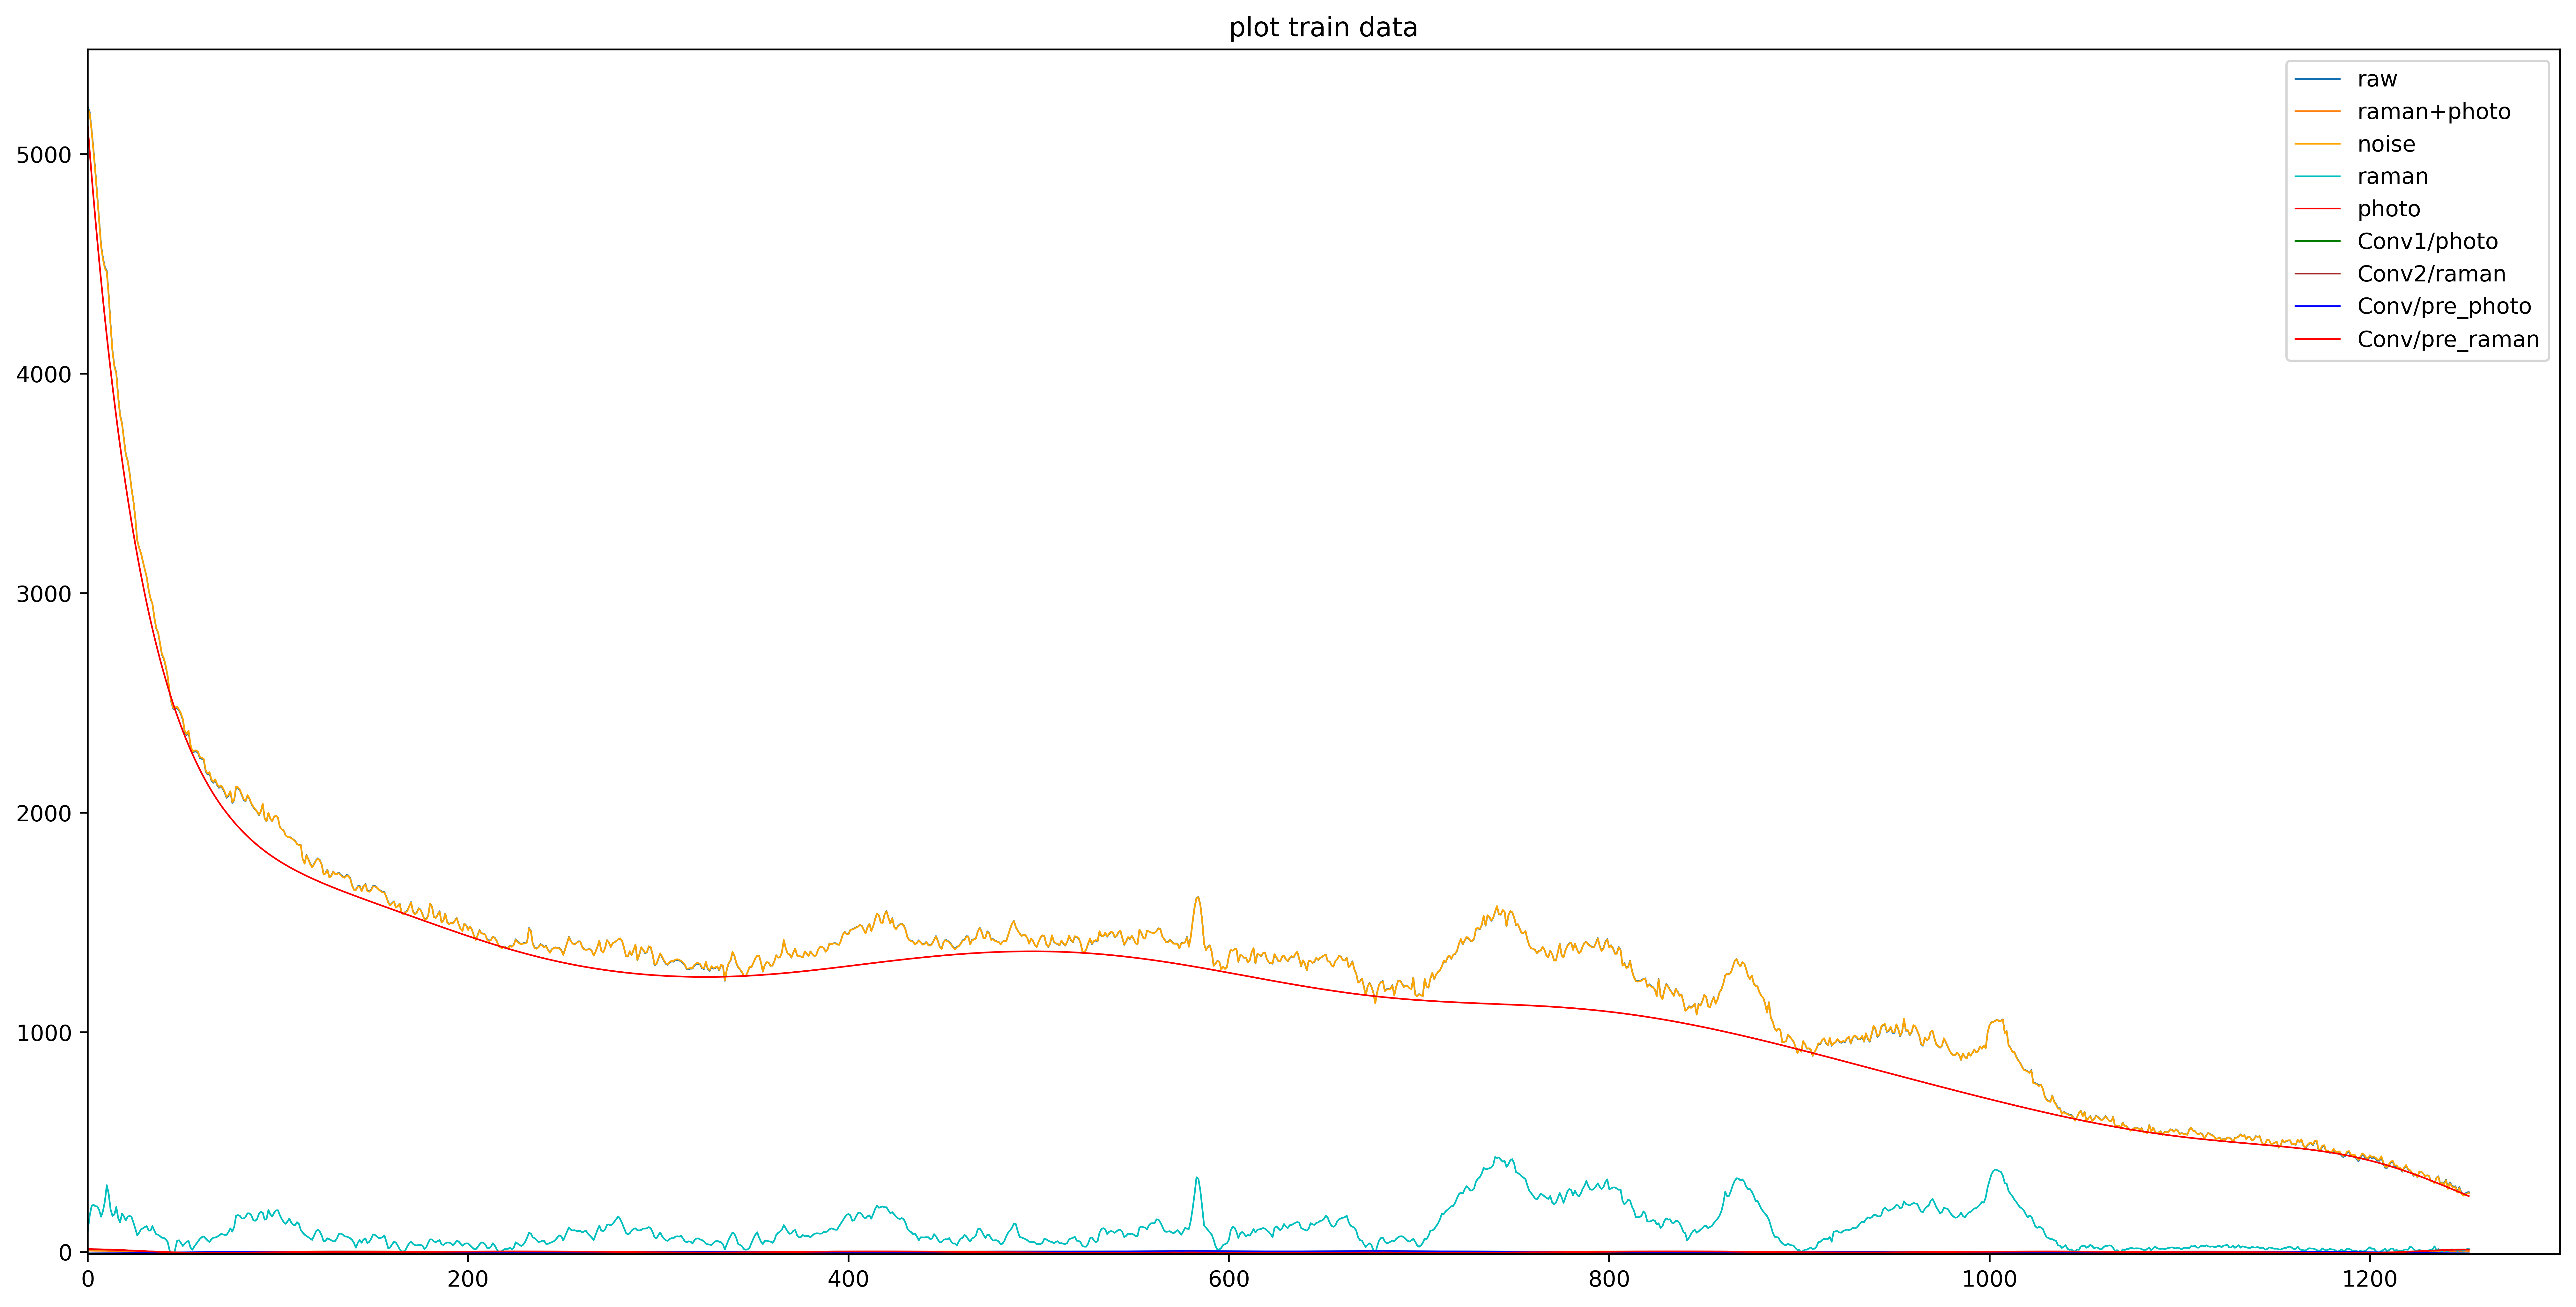

  2022-12-19 14:27:18|     0/ 5391| bits: 1.100572


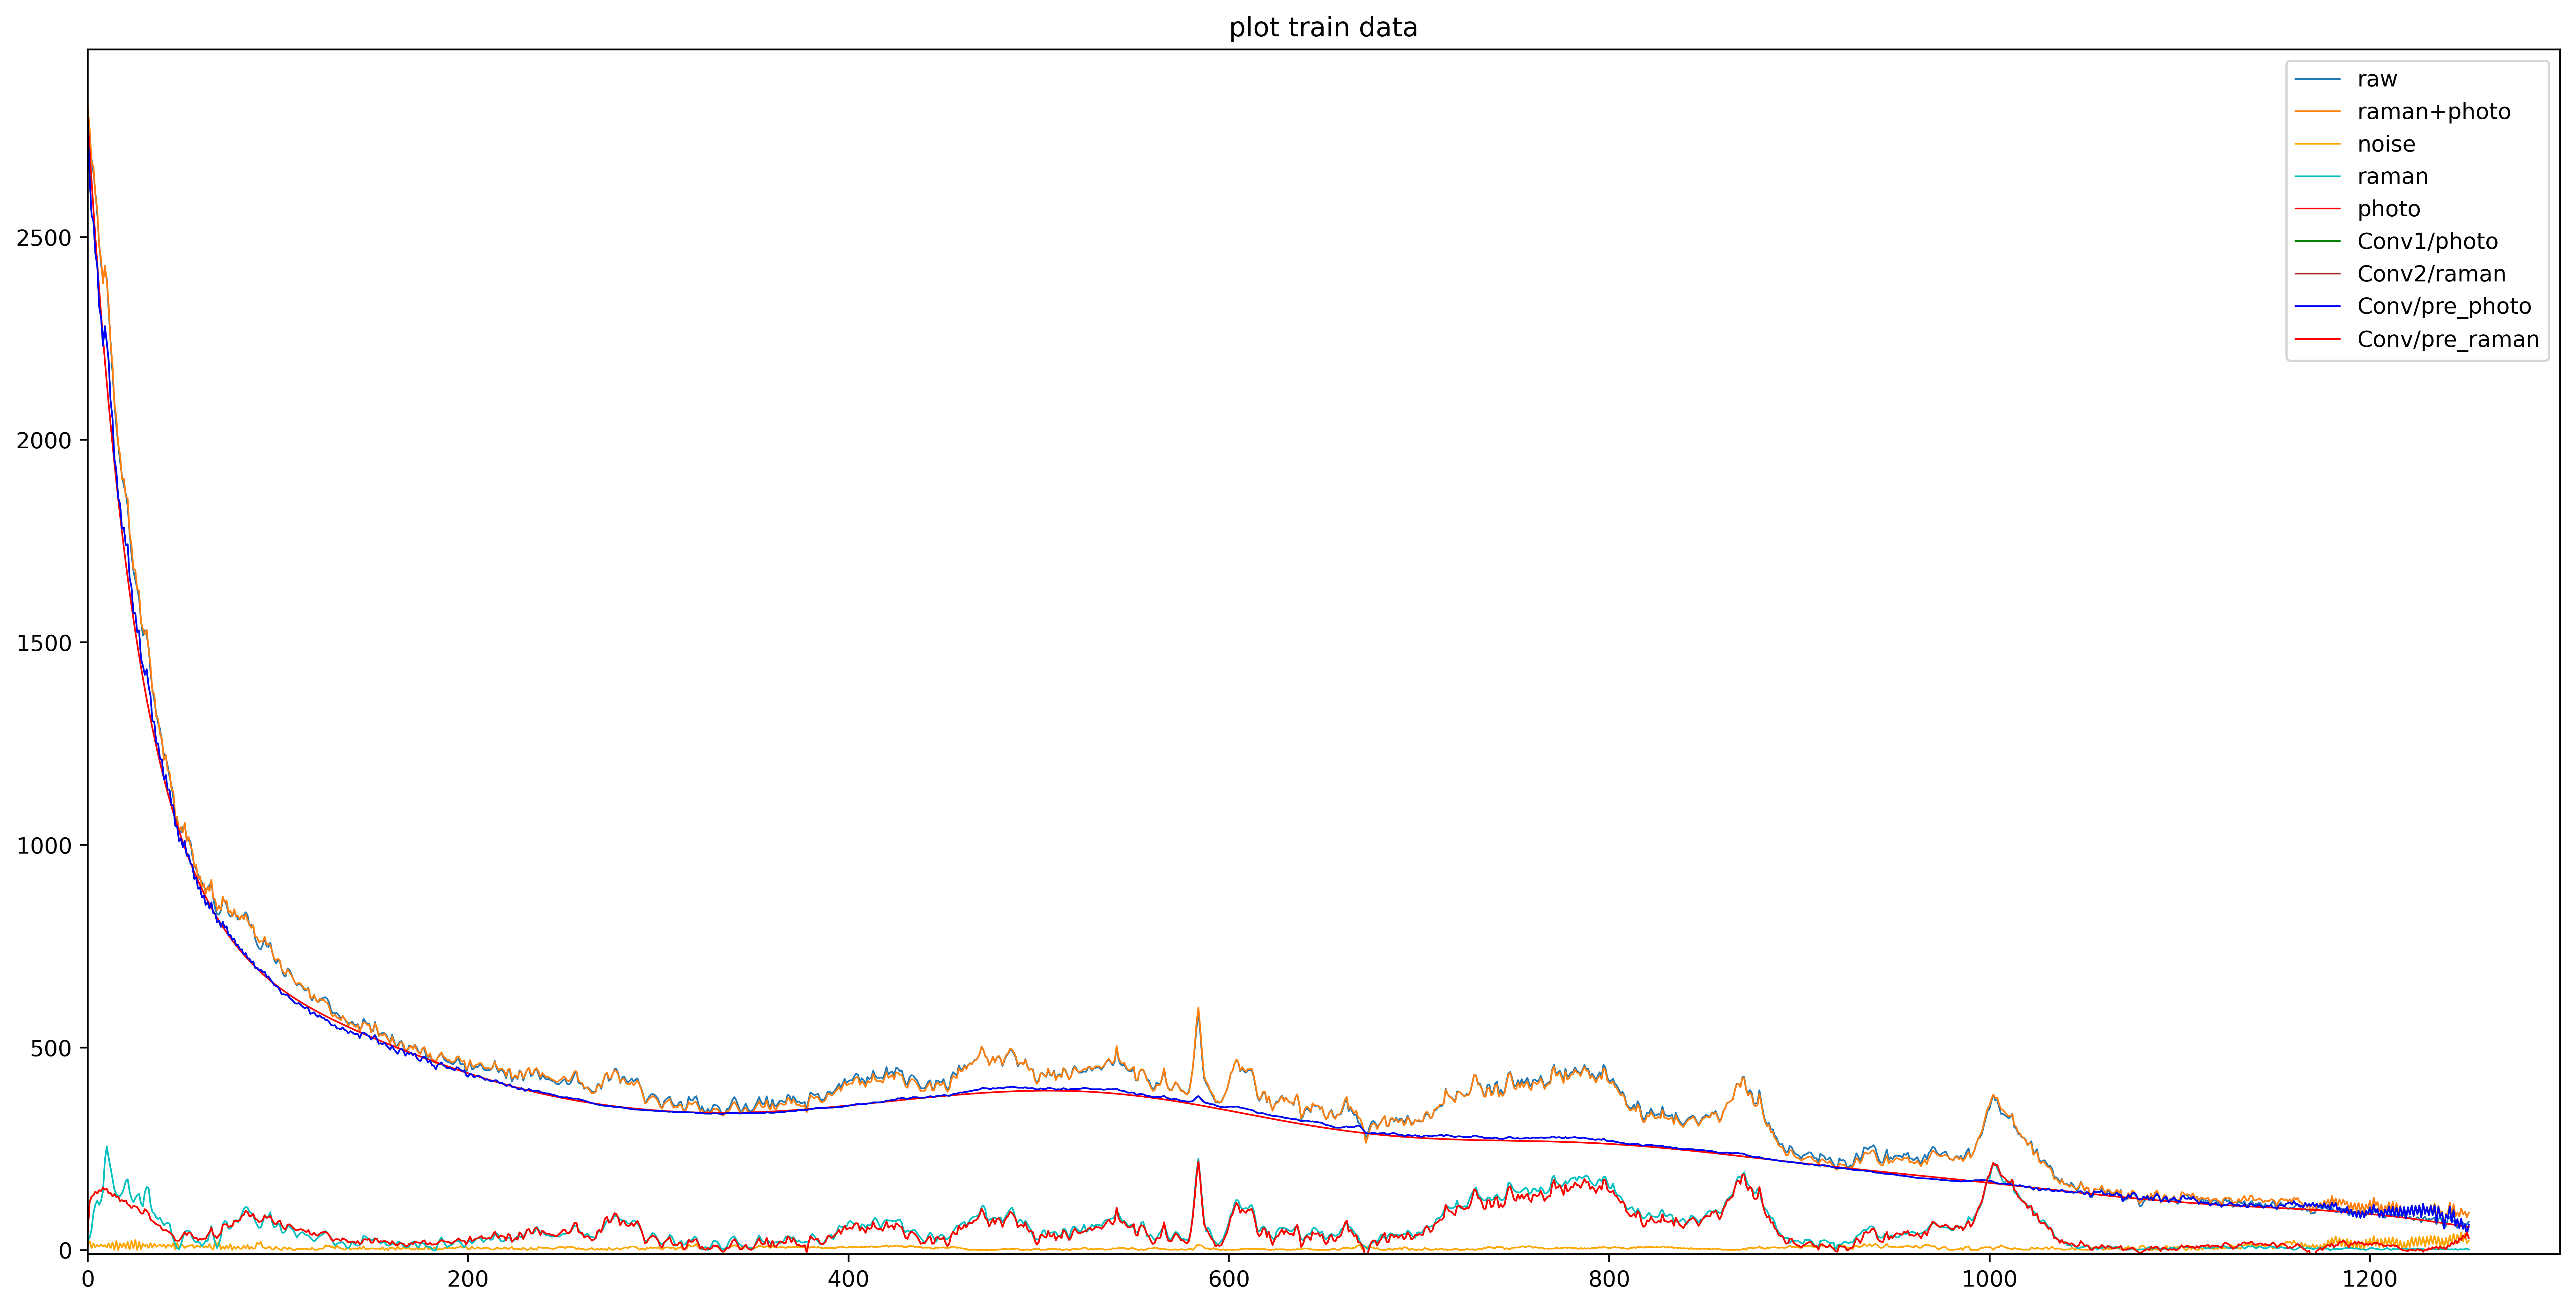

  2022-12-19 14:28:37|  5000/ 5391| bits: 0.000655
Elapsed time: 0h 1m 26s


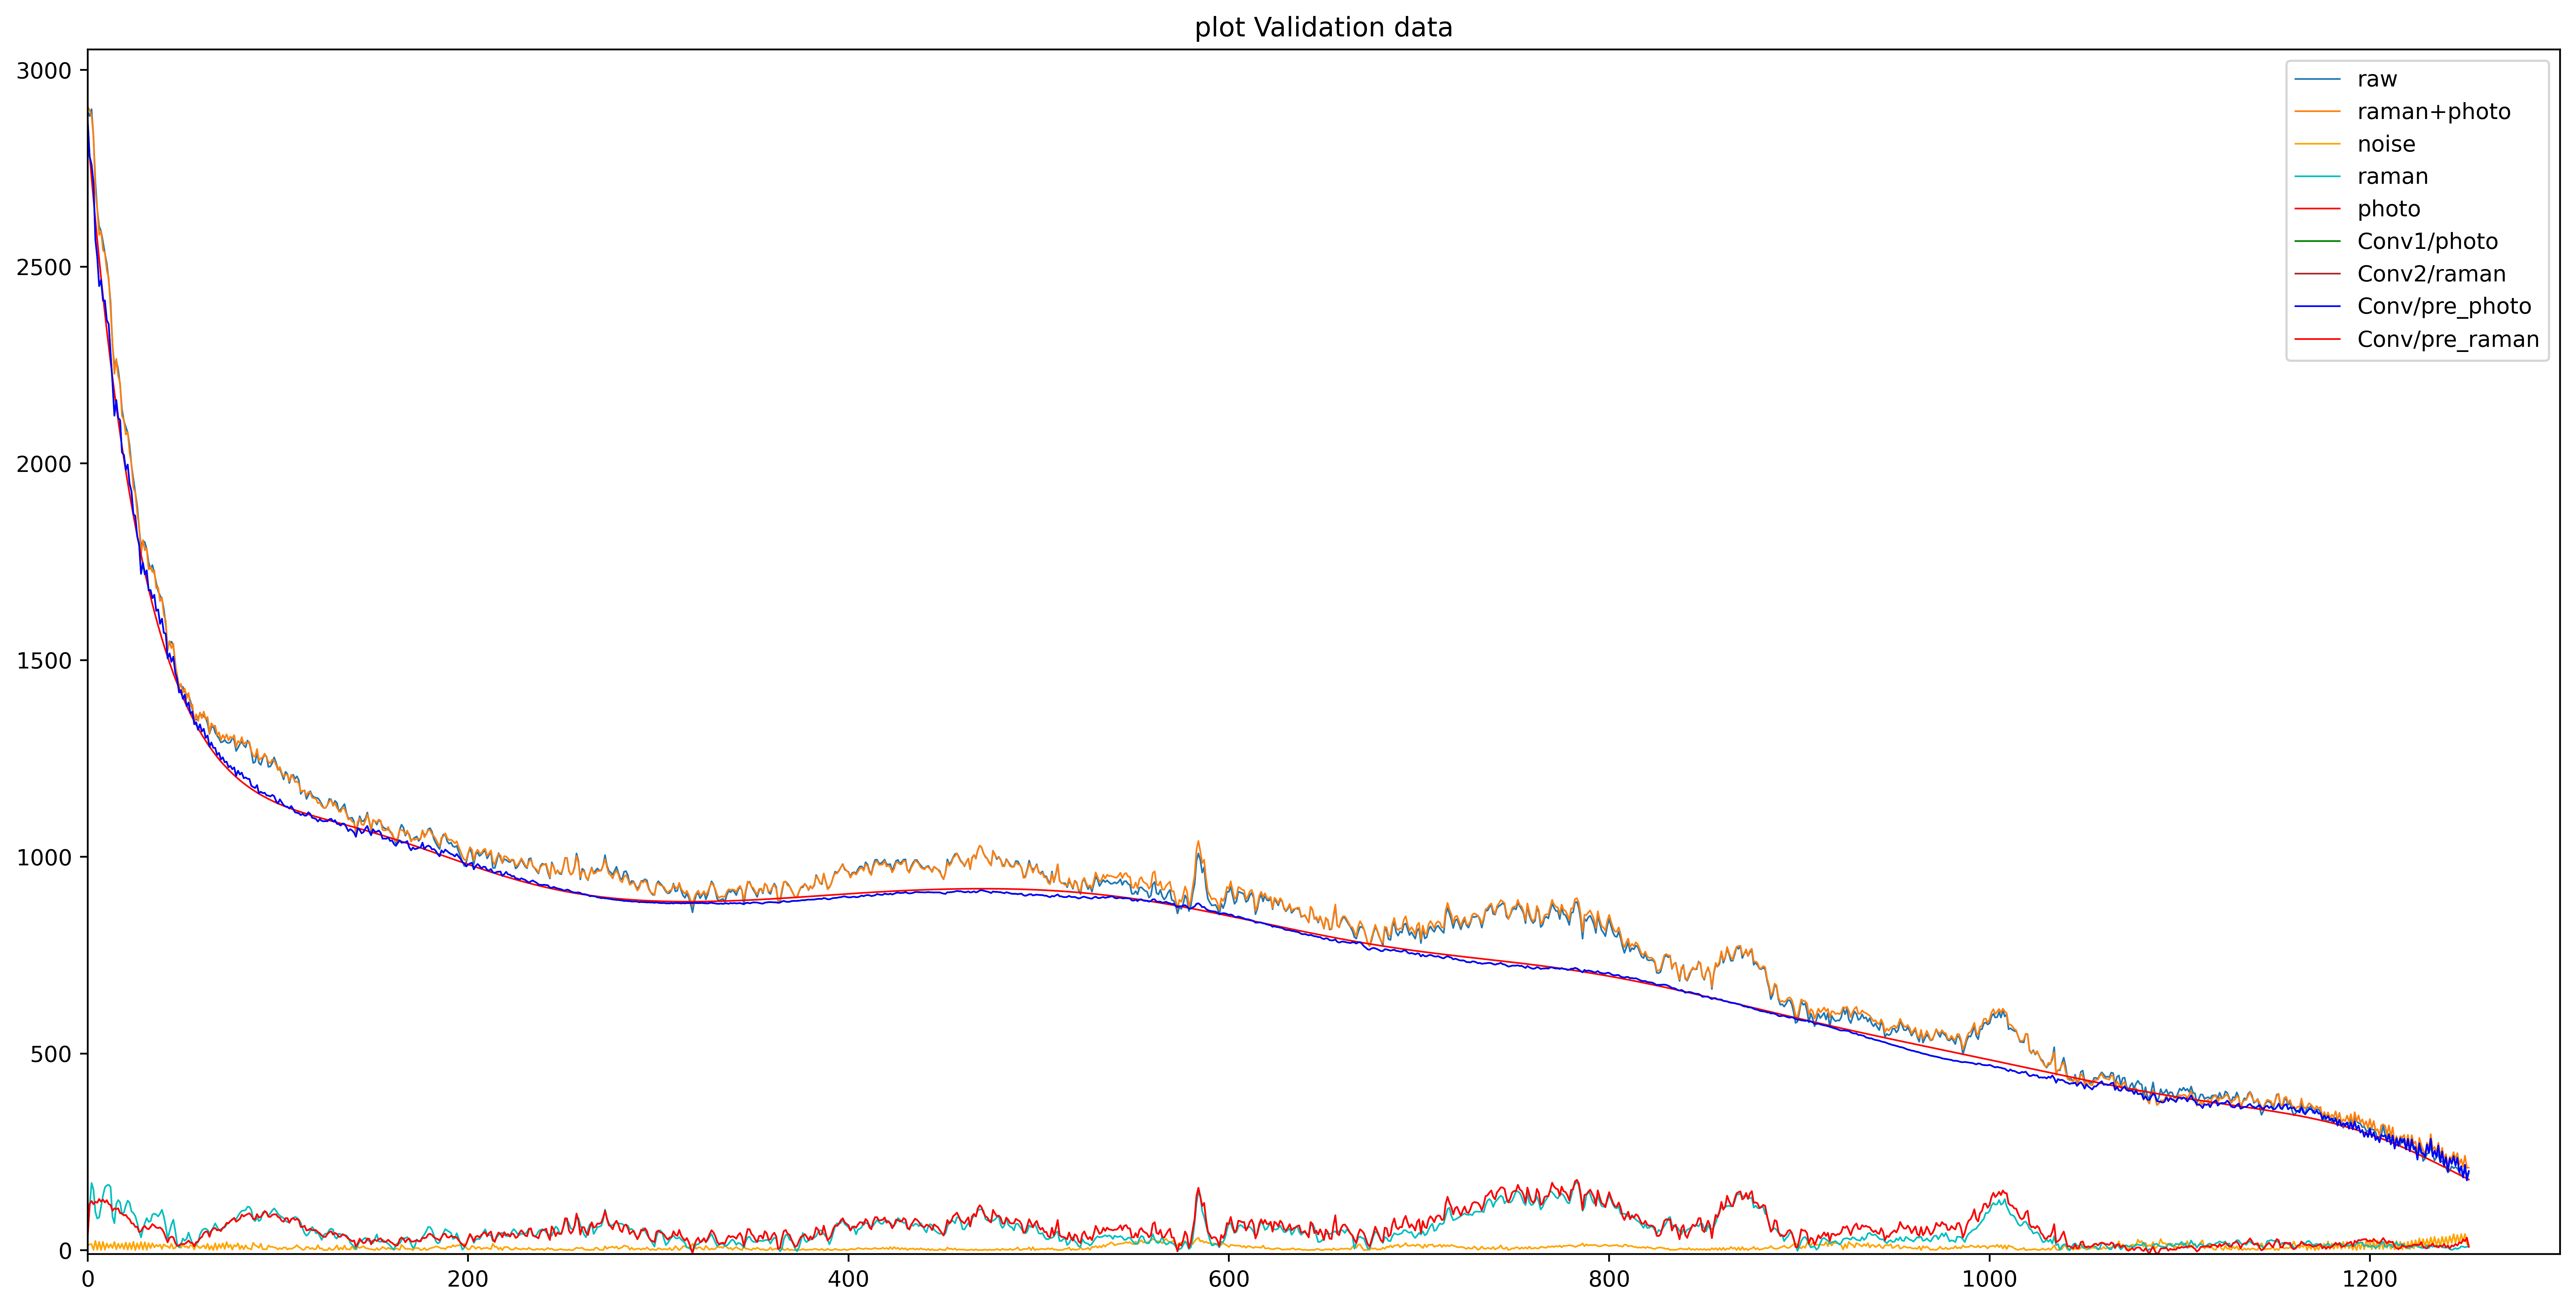

  2022-12-19 14:28:45|     0/  586| bits: 0.000390
Validation average loss: 0.0005639580194838345
--------------------------------------------------
Epoch   1/ 50


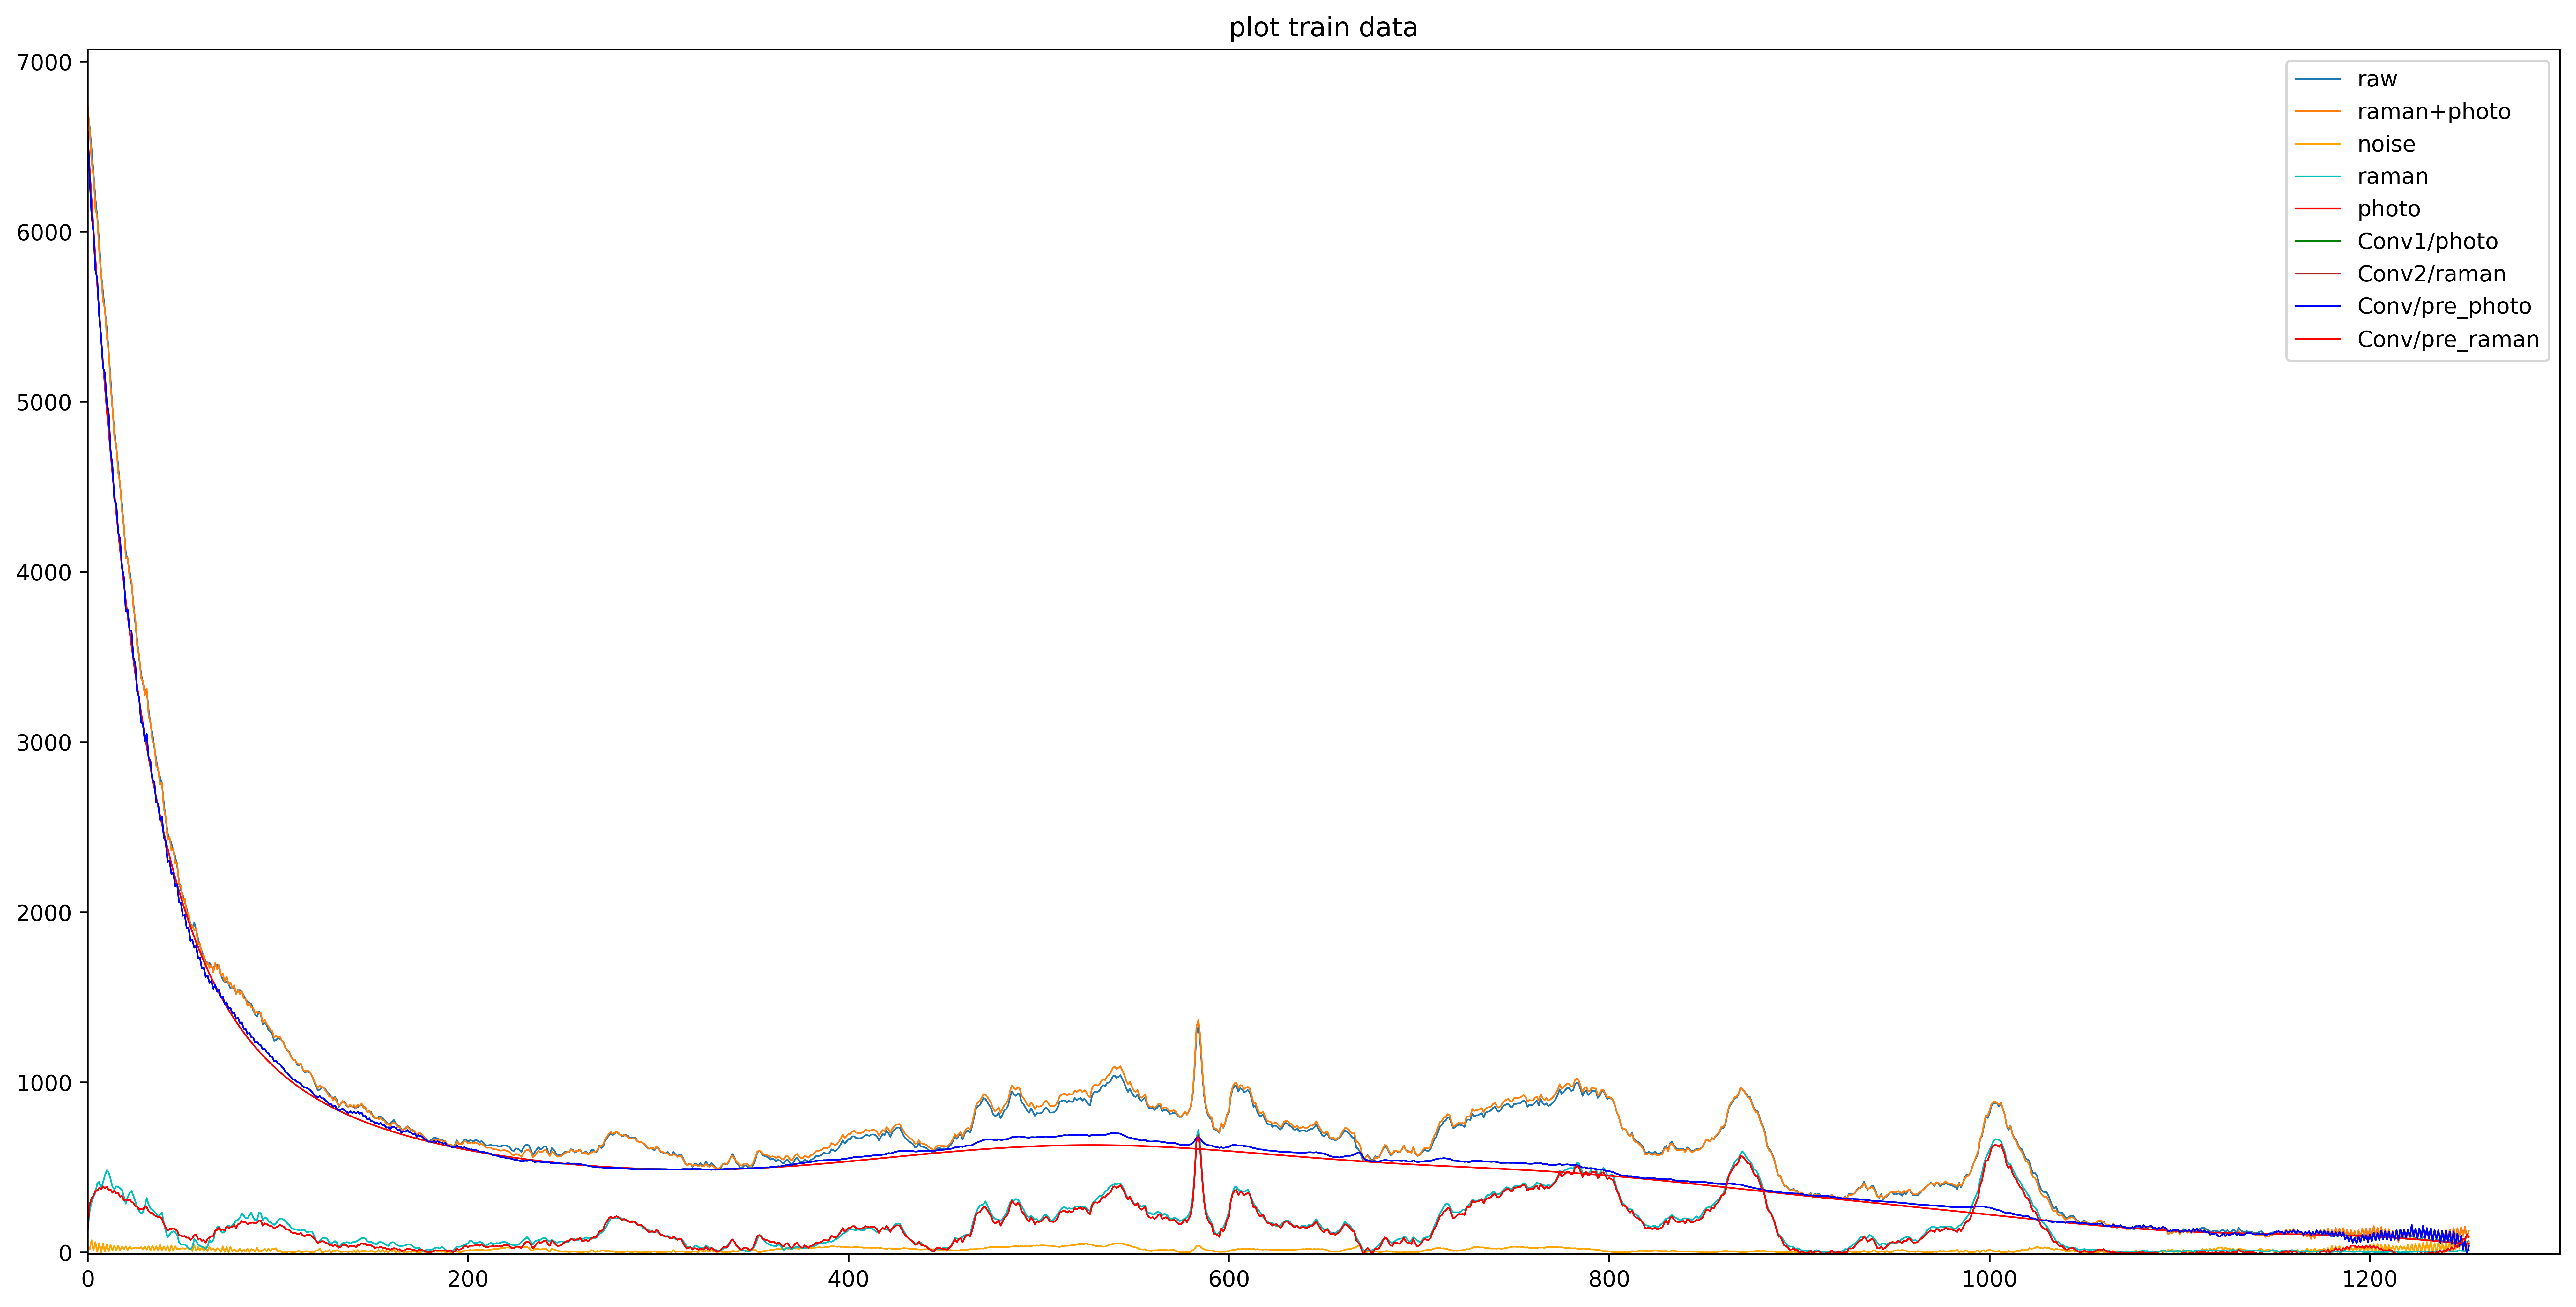

  2022-12-19 14:28:50|     0/ 5391| bits: 0.001008


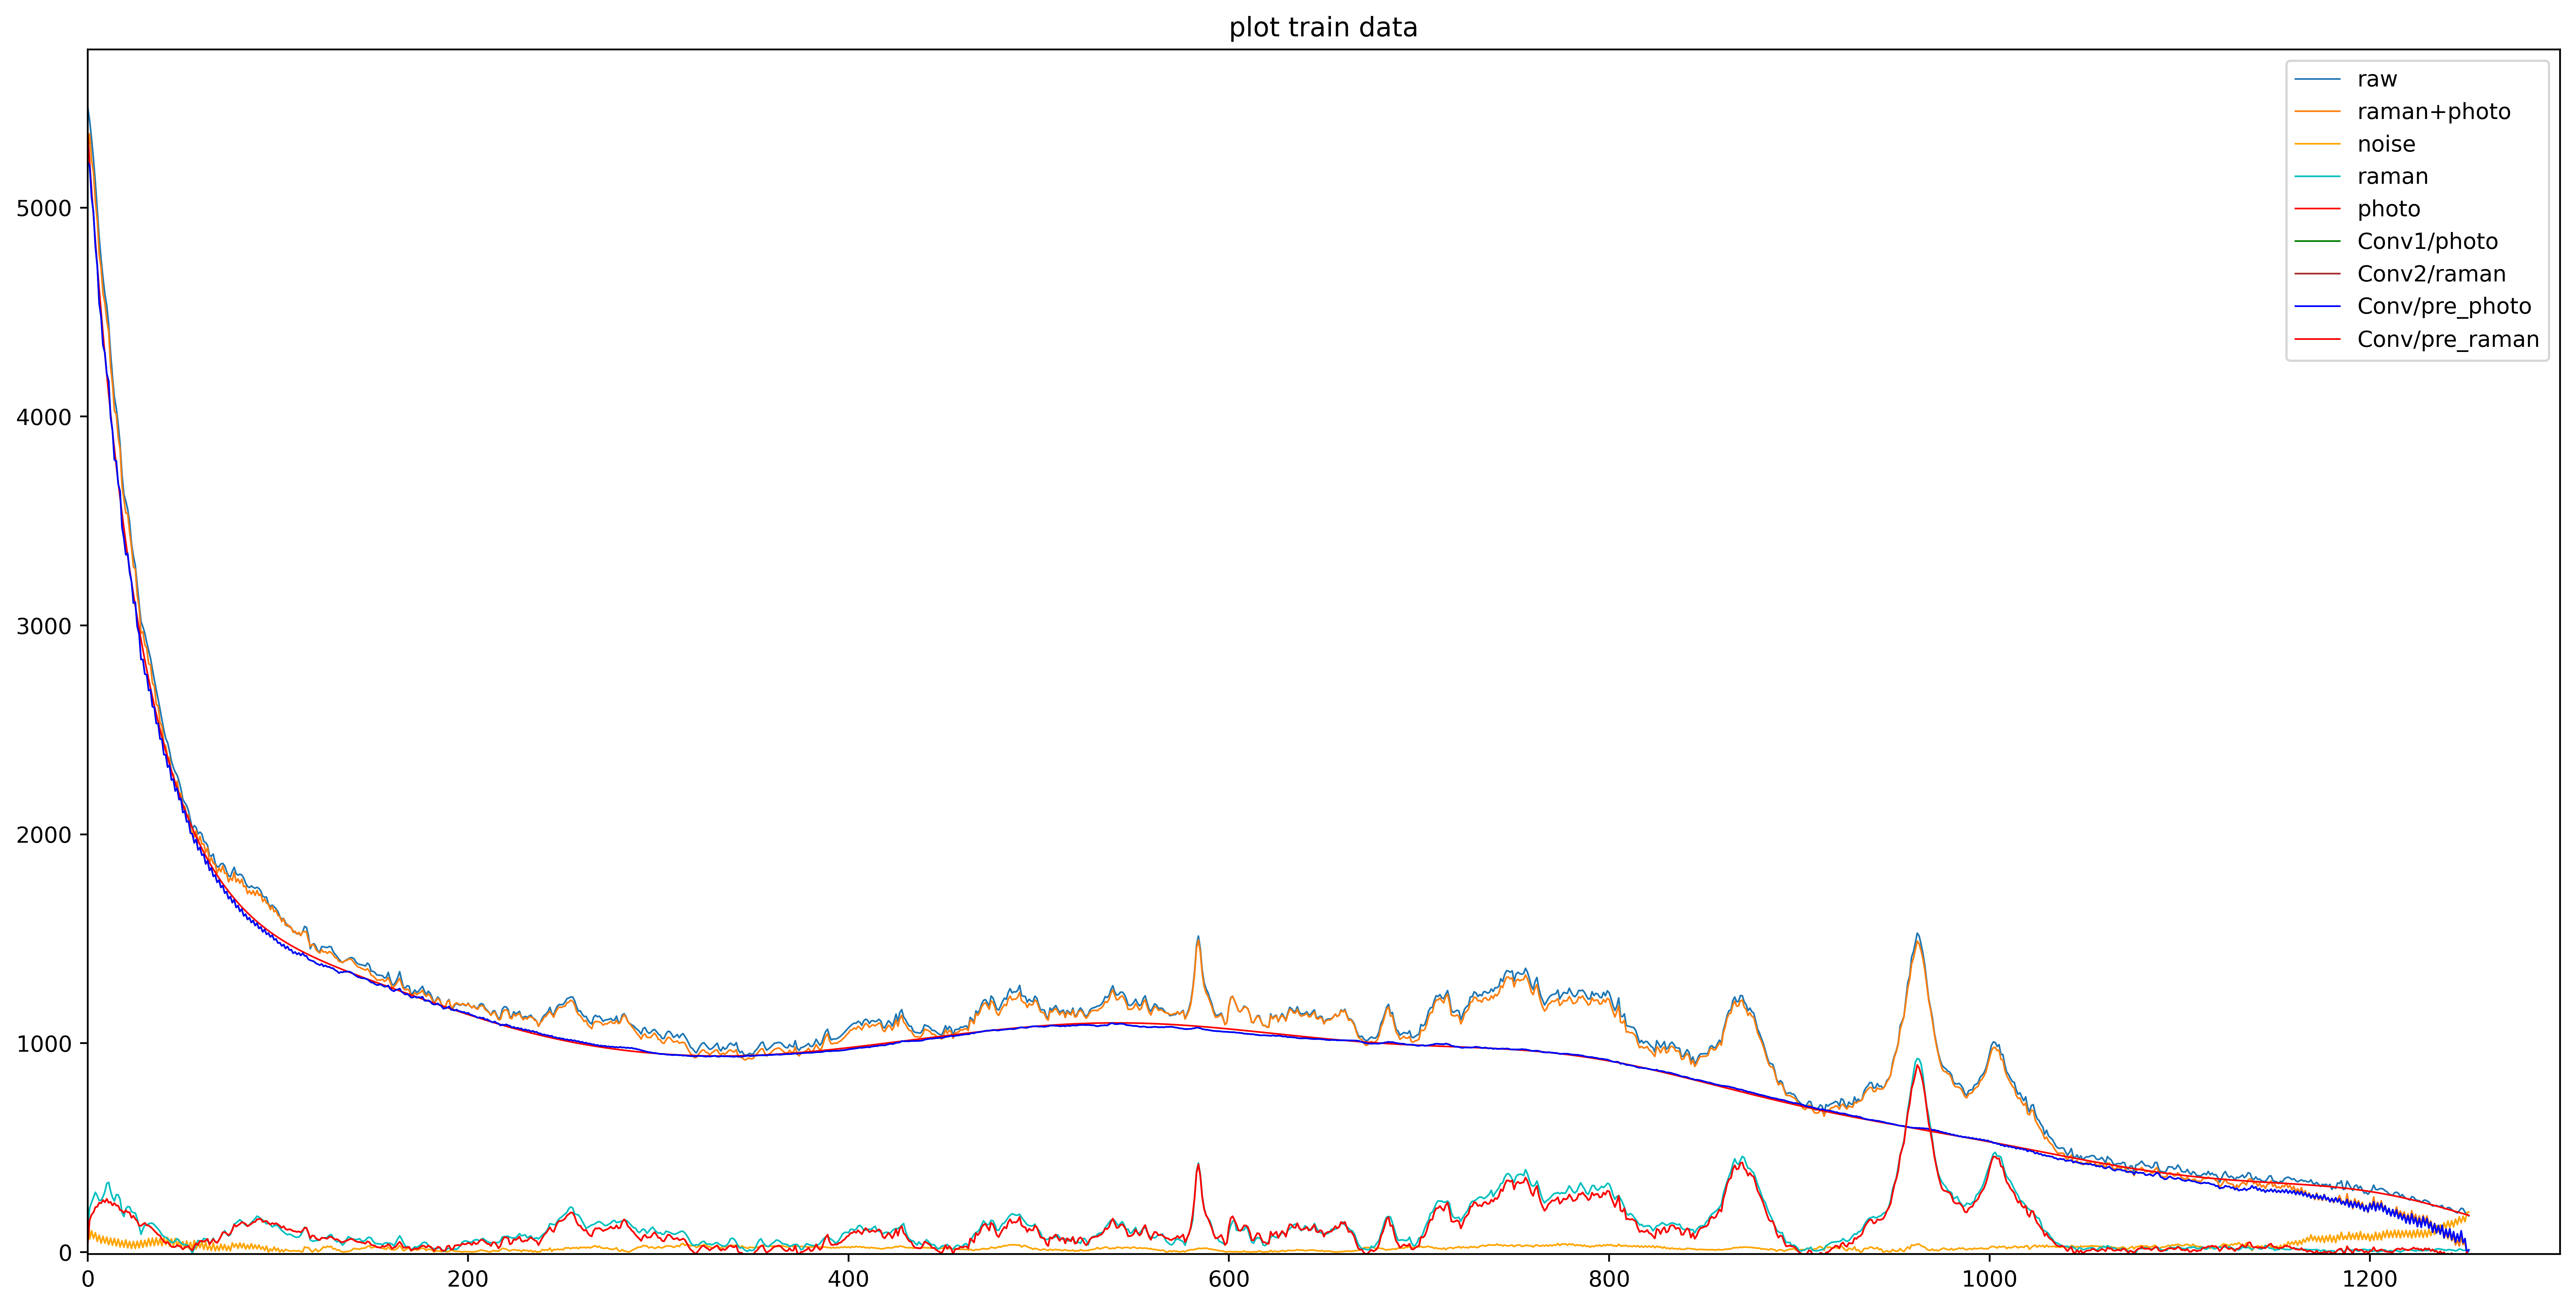

  2022-12-19 14:30:09|  5000/ 5391| bits: 0.001167
Elapsed time: 0h 1m 28s


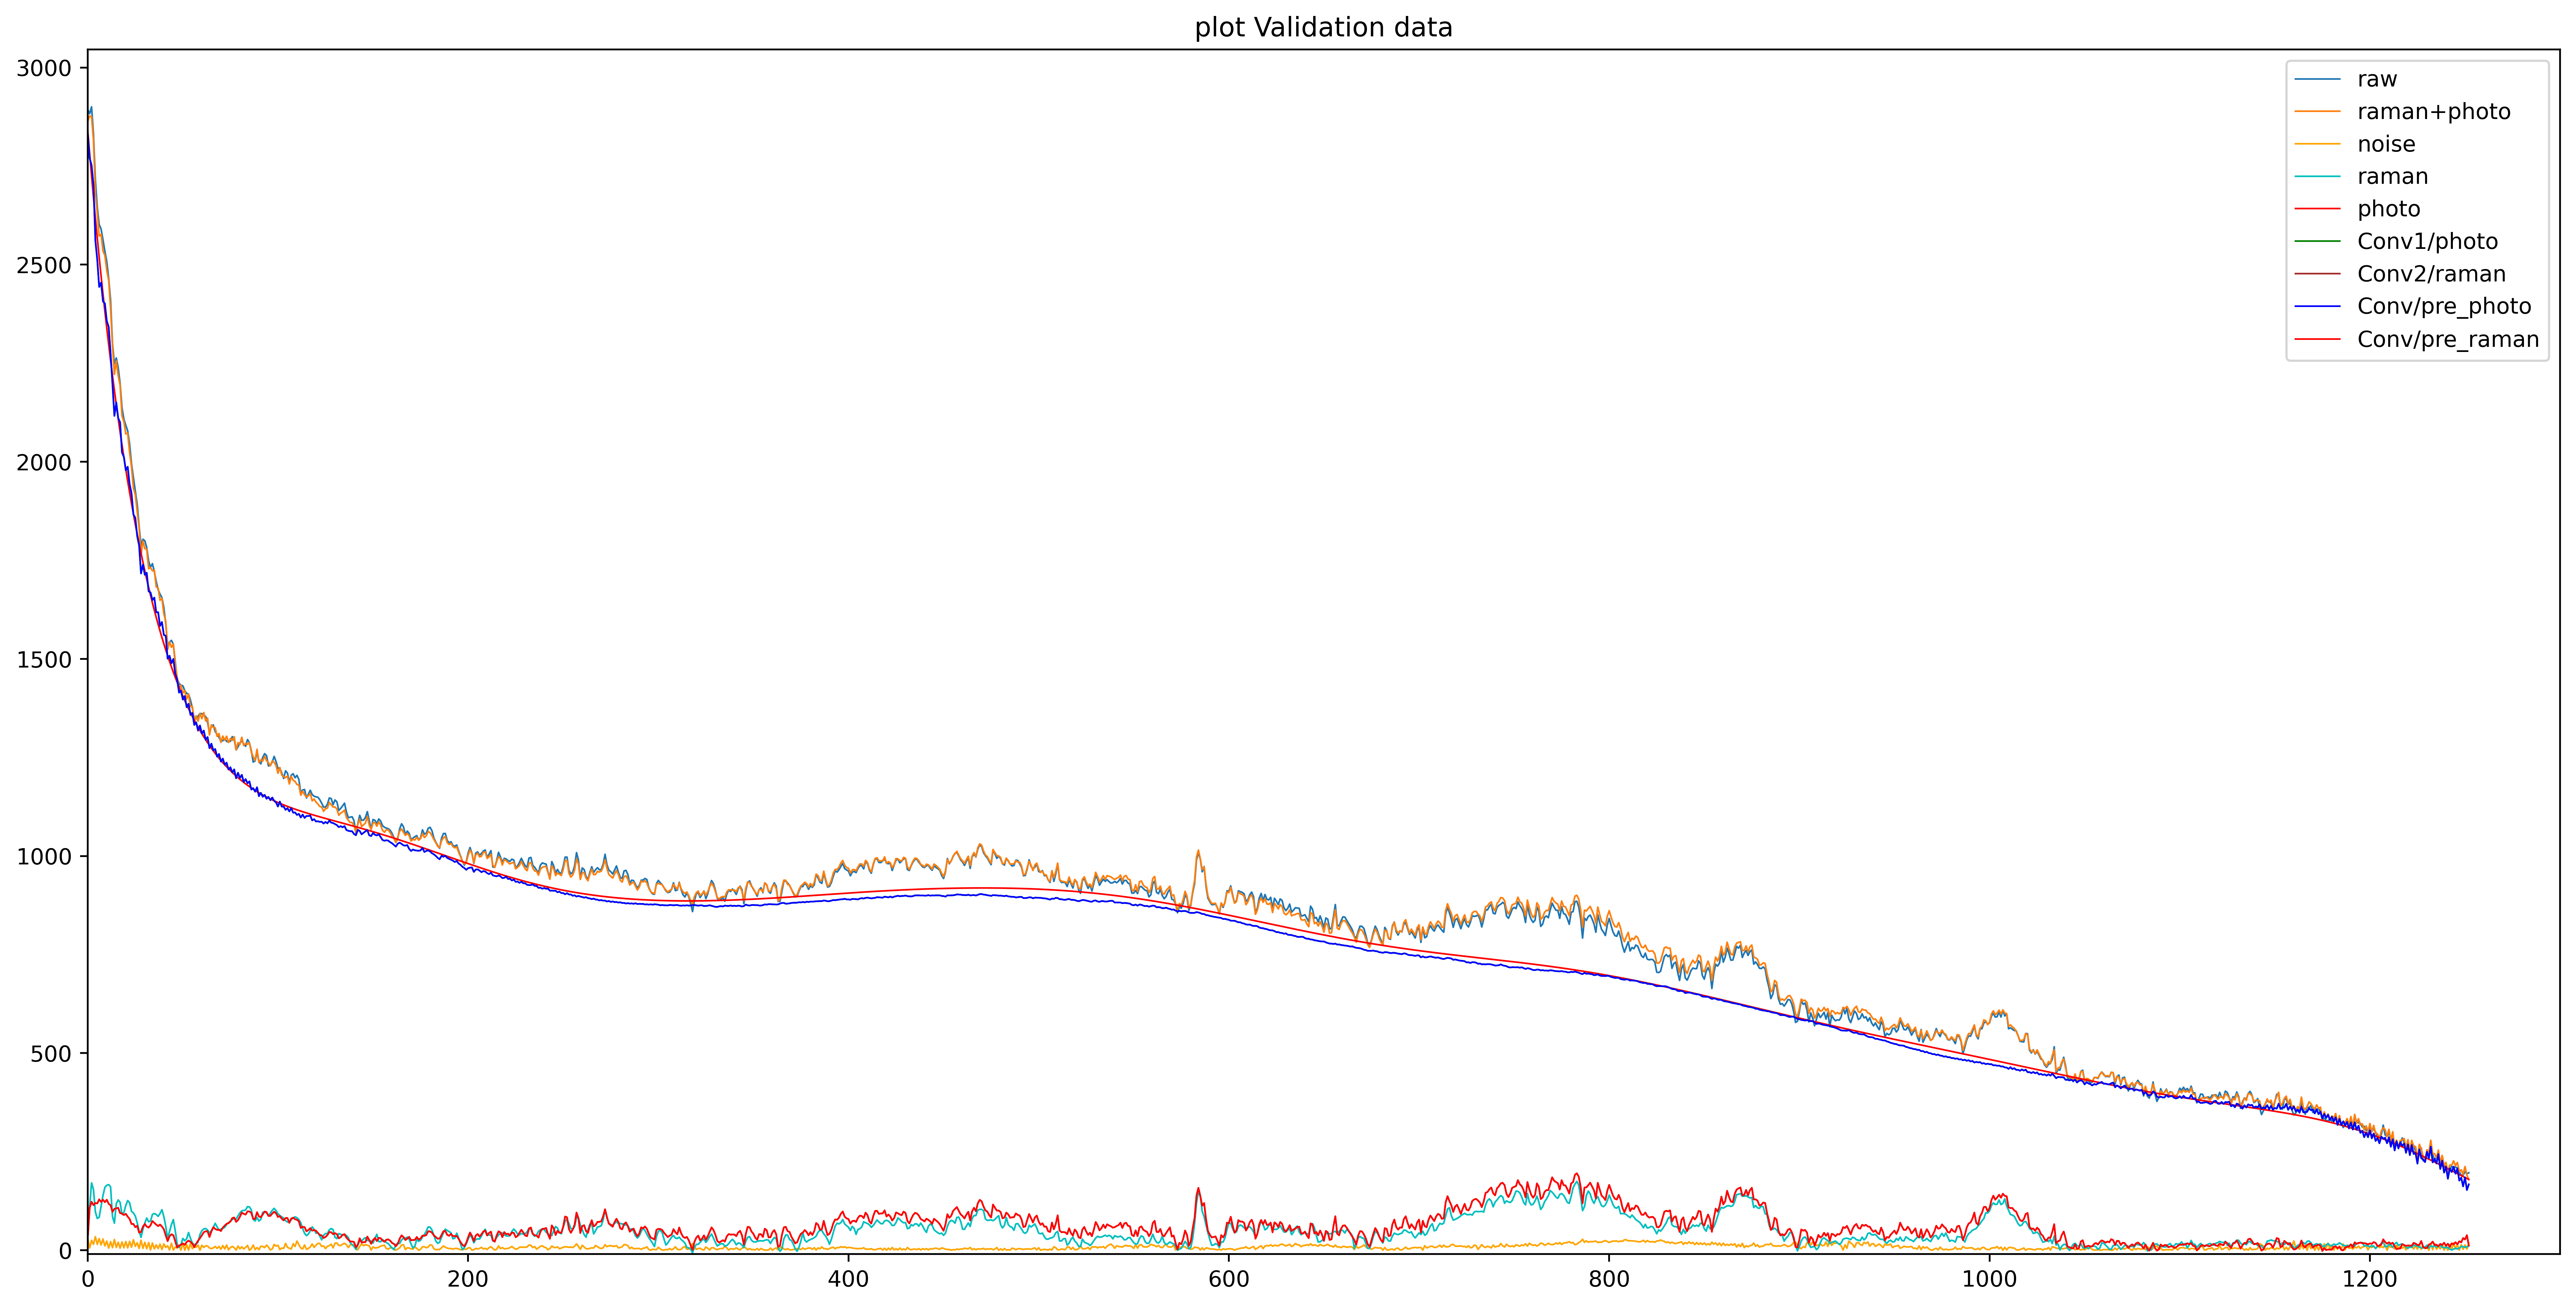

  2022-12-19 14:30:18|     0/  586| bits: 0.000396


KeyboardInterrupt: 

In [9]:
rvc = SupervisedClassifier(**kwargs)
rvc.fit(data)


In [ ]:
s = 0
for parameter in rvc.model.parameters():
    print(np.prod(parameter.shape), parameter.shape)
    s += np.prod(parameter.shape)
s

In [ ]:
# # DESKTOP
# file_locations = ["../data/Raman_Mouse/preprocessed_2022-11-30 11-48-26.672496/",
#                   "../data/Raman_Mouse/raman_2022-11-30 12-16-11.285597/",
#                   "../data/Raman_Mouse/photoluminences_2022-11-30 12-16-25.050493/"]
# # LAPTOP
# # file_locations = ["../data/Raman_Mouse/preprocessed_2022-12-01 11-53-44.127304/",
# #                   "../data/Raman_Mouse/raman_2022-12-01 12-13-34.452351/",
# #                   "../data/Raman_Mouse/photoluminences_2022-12-01 12-13-35.526177/"]
# # filenames = [sorted(glob.glob(file_location+'/[!Wave|!Liver|!Kidney]*.npy')) for file_location in file_locations]
# filenames = [sorted(glob.glob(file_location+'/[!Wave|!muscle]*.npy')) for file_location in file_locations]
# # filenames = [sorted(glob.glob(file_location+'/[!Wave]*.npy')) for file_location in file_locations]

# saved_NN = "saved_NN"
# os.makedirs(saved_NN, exist_ok=True)

# basenames = [[os.path.splitext(os.path.basename(f))[0] for f in filename] for filename in filenames]

# # check if all files exist
# for name in basenames[0]:
#     if not [b for b in basenames[1] if name in b]:
#         raise ValueError(f"file {name} does not exist in the raman folder.")
#     if not [b for b in basenames[2] if name in b]:
#         raise ValueError(f"file {name} does not exist in the photo folder.")

# if len(filenames[0]) != len(filenames[1]) or len(filenames[1]) != len(filenames[2]):
#     raise ValueError("The folder do not have the same number of files.")
        

# with open(f"{'/'.join(file_locations[0].split('/')[:-2])}/Sample_labels.pickle", 'rb') as f:
#     labels = pickle.load(f)
# labels = {l.split(".")[0]: val for l, val in labels.items()}
# labels = list(zip(*sorted(labels.items())))[1]

# wavenumbers = np.load(f"{file_locations[2]}Wavenumbers.npy")

# NORM = False
# func = unit_vector_norm if NORM else lambda x:x
    
# data = []
# for filename in filenames:
#     tmp = []
#     for f in filename: 
#         x = np.load(f)
#         tmp.append(func(x.reshape(-1,x.shape[-1])).reshape(x.shape))
#     data.append(tmp)
# data.append(labels)

# data = list(zip(*data))

In [ ]:
# for i, (x, y1, y2, y_1, y_2, y_3, y_4) in enumerate(rvc.predict(data)):
#     if not i % (3750 // 64):
#         indices = np.random.choice(BATCH_SIZE, 1, replace=False)
#         for i in indices:
#             plt.plot(x[i], label='raw')
#             plt.plot(y_1[i] + y_2[i], label='raman+photo')
#             plt.plot(y1[i], label='raman')
#             plt.plot(y2[i], label='photo')
#             plt.plot(y_1[i], label='Conv1/photo')
#             plt.plot(y_2[i], label='Conv2/raman')
# #             plt.plot(y_3[i], label='Conv2/pre photo')
# #             plt.plot(y_4[i], label='Conv2/pre raman')            
#             plt.plot(np.abs(x[i]-y_1[i]-y_2[i]), label='noise')
#             plt.ylim(ymin=-10)
#             plt.xlim(xmin=0, xmax=1300)
#             plt.legend()
#             plt.show()